# GRIDtools Example 1: Getting an area weighted volume of precipitation across a watershed

Perform the necessary imports, GRIDtools install of v0.0.7 may still require you to set up an environment with the necessary dependencies.

In [1]:
import pynhd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import numpy as np
from chmdata.thredds import GridMet, BBox
import GRIDtools as gt

Let's create a Geopandas GeoDataFrame of a couple of points within the Lolo Watershed in western Montana. Also, a "name" column is added to provide a unique ID to each point.

In [2]:
# Create geopandas.GeoDataFrame of some points we want to delineate upstream catchments for
pour_pnt = gpd.GeoDataFrame(
    {
        "name": ["Lolo_Catchment", "Bear_Creek_Catchment"]
    },
    geometry=[Point(-114.133170, 46.748808),
              Point(-114.324042, 46.766956)],
    crs=4326
)

Use GRIDtools delineate watershed function with the GeoDataFrame as input to get the drainage areas upstream of the points.

In [3]:
# Use delineate_watershed function to get polygon's of the contributing drainage area upstream of each point in GeoDataFrame
result = gt.delineate_watershed(pour_pnt)

In [4]:
# view table
result

,req_idx,catchmentID,geometry,Area_sqKm,name,direction,upstream,gnis_name,comid,reachcode,intersection_point
0,1,NaN,"POLYGON ((-114.35519 46.82845, -114.35519 46.8...",28.379194,Bear_Creek_Catchment,up,True,Bear Creek,24321310,17010205001011,"[-114.32473199573879, 46.76647114978662]"
1,0,NaN,"POLYGON ((-114.65629 46.739, -114.65629 46.739...",653.531430,Lolo_Catchment,up,True,Lolo Creek,24319270,17010205000088,"[-114.12979611165137, 46.747740712007136]"


You can see that the result returns another Geopandas GeoDataFrame that contains POLYGON geometries for the upstream drainage areas. The original uniqe ID (in this case the "name" column) is retained and additional attributes are returned including the Area in square Kilometers, the GNIS_name of the NHD segment that each point intersected, as well as its comid and reachcode. The catchmentID is NaN because it is a custom delineation so it does not conform to a known HUC. The intersection point is the flow direction trace intersection point from the original input point and where it intersected an NHD stream segment.

We can use Geopandas to visualize the output POLYGONs.

<Axes: >

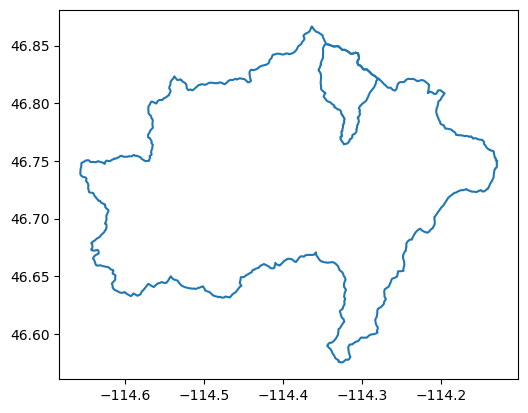

In [5]:
# plot watershed boundaries
result.boundary.plot()

## Get GridMET Precipitation Data

Next we will use DNRC's chmdata package to get some precipitation data for the delineated watersheds.

In [25]:
# Use chmdata to get GridMET precipitation data for the area of interest
# Create the bbox
bnds = result.total_bounds
bbox = BBox(bnds[0]-0.5, bnds[2]+0.5, bnds[3]+0.5, bnds[1]-0.5)
gmet = GridMet(variable='pr', start='2016-01-01', end='2024-12-01', bbox=bbox)
prcp = gmet.subset_nc(return_array=True)

This returns an xarray Dataset for the given bounding box. We can use Matplotlib to visulaize the grided data (in this case the total sum for the period requested 2016-01-01 to 2024-12-01).

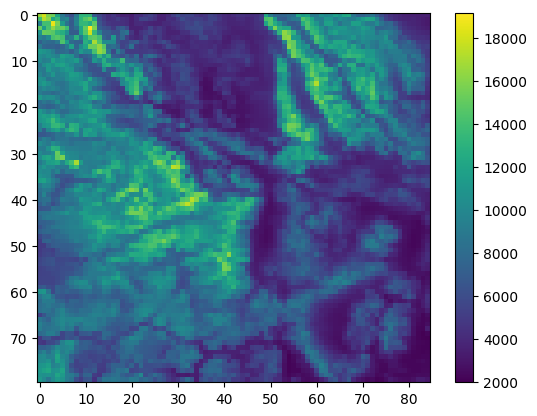

In [7]:
# view cumulative precip over the time period
plt.imshow(prcp.precipitation_amount.sum(dim='time'))
plt.colorbar()

In [26]:
prcp = prcp.rename({'lat': 'y', 'lon': 'x', 'crs': 'spatial_ref'})

In [45]:
from rasterio.enums import Resampling
prcp.rio.write_crs(4326, inplace=True)
prcp_proj = prcp.rio.reproject(5071, resampling=Resampling.nearest, nodata=np.nan)

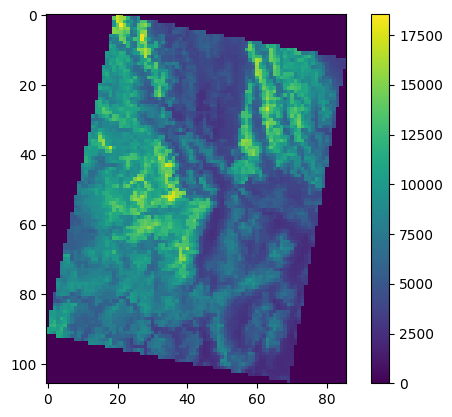

In [49]:
plt.imshow(prcp_proj.precipitation_amount.sum(dim='time'))
plt.colorbar()

In [55]:
prcp_proj['precipitation_amount'] = prcp_proj.precipitation_amount / 1000

In [62]:
import xvec
t_geom = result.to_crs(5071)
exac = prcp_proj.xvec.zonal_stats(t_geom.geometry, x_coords='x', y_coords='y', stats="sum", method='exactextract')

c:\Users\CNB968\.conda\envs\wmbflow\lib\site-packages\exactextract\exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(


In [63]:
exac

<xarray.DataArray (geometry: 2, variable: 1, time: 3258)> Size: 52kB
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.00039434]],

       [[0.        , 0.        , 0.00017571, ..., 0.        ,
         0.        , 0.00066541]]])
Coordinates:
  * geometry  (geometry) object 16B POLYGON ((-1397414.0980813543 2784074.063...
  * variable  (variable) object 8B 'precipitation_amount'
  * time      (time) datetime64[ns] 26kB 2016-01-01 2016-01-02 ... 2024-12-01
Indexes:
    geometry  GeometryIndex (crs=EPSG:5071)
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.0
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       24 January 2025
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [77]:
areas = exac.sel(time='2016-01-01').xvec.to_geodataframe(name='t1').geometry.area

In [80]:
areas.values

array([2.83791938e+07, 6.53531430e+08])

C:\Users\CNB968\AppData\Local\Temp\ipykernel_35984\3935042580.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(exac.time.values, exac.isel(geometry=i, variable=0).values * areas.values[i], marker=None, ls='solid', label=i, alpha=0.6)


Text(0, 0.5, 'Daily Precipitation Volume ($m^3$)')

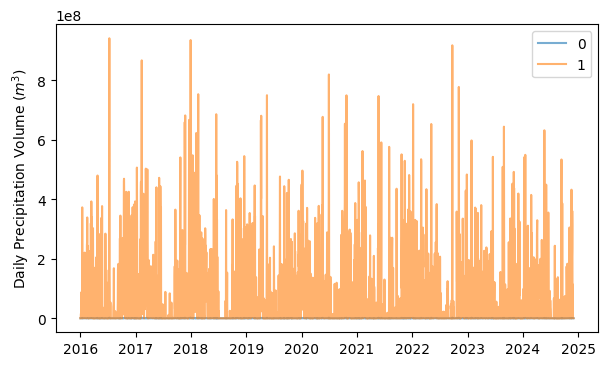

In [82]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
for i in range(len(exac.geometry.values)):
    ax.plot_date(exac.time.values, exac.isel(geometry=i, variable=0).values * areas.values[i], marker=None, ls='solid', label=i, alpha=0.6)
ax.legend()
ax.set_ylabel('Daily Precipitation Volume ($m^3$)')

Next we can use the precipitation_amount DataArray as input to the GRIDtools grid_area_weighted_volume function, along with our geometries of interest (in this case the output of the delineate watershed function), and then a specification of which column in the input GeoDataFrame we would like to use as location ID's in the resulting dataset.

In [51]:
vol = gt.grid_area_weighted_volume(prcp.precipitation_amount / 1000, result, geom_id_col='name')

Viewing the result we see that the output is another xarray Dataset that contains dimensions of time and location (polygons), there is a coordinate variable denoting the location ID, also a coordinate variable that contains the input polygon area in square kilometers.

The data variable of the output is the precip_volume in cubic meters.

In [52]:
vol

<xarray.Dataset> Size: 78kB
Dimensions:        (time: 3258, location: 2)
Coordinates:
  * location       (location) <U20 160B 'Bear_Creek_Catchment' 'Lolo_Catchment'
    area           (location) float64 16B 28.38 653.5
  * time           (time) datetime64[ns] 26kB 2016-01-01 ... 2024-12-01
Data variables:
    precip_volume  (time, location) float64 52kB 0.0 2.825e+04 0.0 ... 0.0 0.0
Attributes:
    featureType:  timeSeries

## Visualize the Results

C:\Users\CNB968\AppData\Local\Temp\ipykernel_35984\1750784007.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(vol.time.values, vol.precip_volume.sel(location=i).values, marker=None, ls='solid', label=i, alpha=0.6)
C:\Users\CNB968\AppData\Local\Temp\ipykernel_35984\1750784007.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot_date(vol.time.values, vol.precip_volume.sel(location=i).cumsum().values, marker=None, ls='solid', label=i)
C:\Users\CNB968\AppData\Local\Temp\ipykernel_35984\1750784007.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot_date(vol.time.values, vol.precip_volume.sel(location=i).cumsum().valu

Text(0, 0.5, 'Annual Total Precip Volume ($m^3$)')

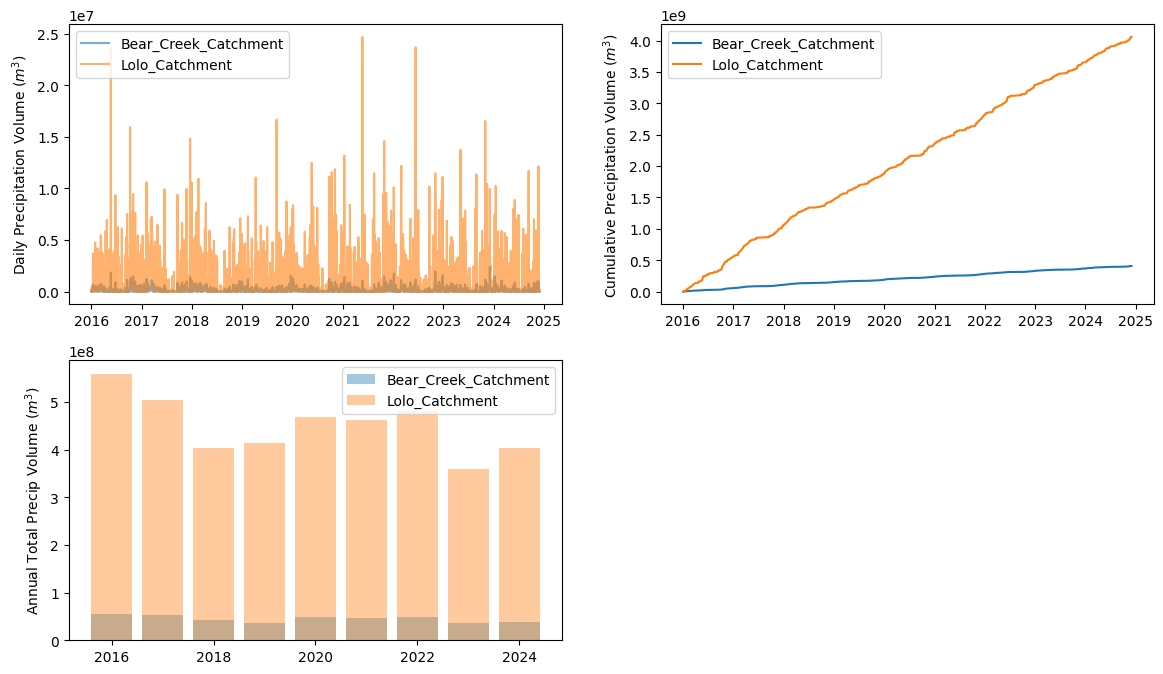

In [53]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
for i in vol.location.values:
    ax.plot_date(vol.time.values, vol.precip_volume.sel(location=i).values, marker=None, ls='solid', label=i, alpha=0.6)
ax.legend()
ax.set_ylabel('Daily Precipitation Volume ($m^3$)')
for i in vol.location.values:
    ax2.plot_date(vol.time.values, vol.precip_volume.sel(location=i).cumsum().values, marker=None, ls='solid', label=i)
ax2.legend()
ax2.set_ylabel('Cumulative Precipitation Volume ($m^3$)')
yr_resamp = vol.resample(time='YE').sum()
for i in vol.location.values:
    ax3.bar(yr_resamp.time.dt.year.values, yr_resamp.precip_volume.sel(location=i).values, label=i, alpha=0.4)
ax3.legend()
ax3.set_ylabel('Annual Total Precip Volume ($m^3$)')